<a href="https://colab.research.google.com/github/Tselmuun0624/CS330-Group-49/blob/main/PINN_Method_for_Reaction_Diffusion_Eq_on_Elliptic_BVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
import scipy.io

from torch.autograd import Variable
from torch.nn import Linear, Module, MSELoss
from torch.optim import SGD
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from scipy import special

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

pi = torch.Tensor([math.pi]).type(torch.float64)

pi = pi.to(DEVICE)
#ep=10**(-8)
#ep=10**(-5)
#ep=10**(-4)
#ep=10**(-3)
ep=10**(-2)
#ep=1

alpha=torch.div(1,ep)
beta = torch.sqrt(alpha)

n0 = -pi/3
n1 = pi/3

r1 = 1
r2 = 2

#r1 = 0.01
#r2 = 1.01

Using PyTorch version: 2.0.1+cu118  Device: cuda


In [ ]:
#########Model setting################
def sig(x):
    return torch.sigmoid(x)

def deri_sig(x,m):

    if m==1:
        return x*(1-x)
    if m==2:
        return x*(1-x)*(1-2*x)



class DU(nn.Module):
    def __init__(self):
        super(DU, self).__init__()
        self.fcr = nn.Linear(1, 32).type(torch.float64)
        self.fcn = nn.Linear(1, 32).type(torch.float64)
        self.fc2 = nn.Linear(32, 1, bias=False).type(torch.float64)


    def forward(self, r,n):
        #x=x.unsqueeze(0).unsqueeze(1)
        l2_weight=torch.transpose(self.fc2.weight,0,1)

        lr_weight=torch.transpose(self.fcr.weight,0,1)
        ln_weight=torch.transpose(self.fcn.weight,0,1)
        sig0=sig(self.fcr(r)+self.fcn(n))
        u=torch.mm(sig(self.fcr(r)+self.fcn(n)),l2_weight)
        u_r=torch.mm(deri_sig(sig(self.fcr(r)+self.fcn(n)),1)*lr_weight,l2_weight)
        u_rr=torch.mm(deri_sig(sig(self.fcr(r)+self.fcn(n)),2)*(lr_weight**2),l2_weight)
        u_n=torch.mm(deri_sig(sig(self.fcr(r)+self.fcn(n)),1)*ln_weight,l2_weight)
        u_nn=torch.mm(deri_sig(sig(self.fcr(r)+self.fcn(n)),2)*(ln_weight**2),l2_weight)
        return u,u_r,u_rr,u_n,u_nn

class Model(nn.
            Module):
    def __init__(self):
        super(Model,self).__init__()
        self.wave=DU()


    def forward(self,r,n):

        u,u_r,u_rr,u_n,u_nn= self.wave(r,n)
        un0,un0_r,un0_rr,_,_ = self.wave(r, n0)
        un1,un1_r,un1_rr,_,_ = self.wave(r, n1)



        theta0 = un0*torch.exp(r*beta*(n0-n)) #theta0
        theta0_r = torch.exp(-(r*(n - n0))/ep**(1/2))*un0_r - (torch.exp(-(r*(n - n0))/ep**(1/2))*un0*(n - n0))/ep**(1/2)
        theta0_rr = torch.exp(-(r*(n - n0))/ep**(1/2))*un0_rr - (2*torch.exp(-(r*(n - n0))/ep**(1/2))*(n - n0)*un0_r)/ep**(1/2) + (torch.exp(-(r*(n - n0))/ep**(1/2))*un0*(n - n0)**2)/ep
        theta0_n = -(r*torch.exp(-(r*(n - n0))/ep**(1/2))*un0)/ep**(1/2)
        theta0_nn = (r**2*torch.exp(-(r*(n - n0))/ep**(1/2))*un0)/ep



        theta1 = un1*torch.exp(r*beta*(n-n1)) #theta1
        theta1_r = torch.exp((r*(n - n1))/ep**(1/2))*un1_r + (torch.exp((r*(n - n1))/ep**(1/2))*un1*(n - n1))/ep**(1/2)
        theta1_rr = torch.exp((r*(n - n1))/ep**(1/2))*un1_rr + (2*torch.exp((r*(n - n1))/ep**(1/2))*(n - n1)*un1_r)/ep**(1/2) + (torch.exp((r*(n - n1))/ep**(1/2))*un1*(n - n1)**2)/ep
        theta1_n = (r*torch.exp((r*(n - n1))/ep**(1/2))*un1)/ep**(1/2)
        theta1_nn = (r**2*torch.exp((r*(n - n1))/ep**(1/2))*un1)/ep



        U = (r-r1)*(r-r2)*(u - theta0*(n1 - n)/(n1 - n0) - theta1*(n - n0)/(n1 - n0)) #U is the predicted solution

        U_r = (r - r1)*(u - (theta0*(n - n1))/(n0 - n1) + (theta1*(n - n0))/(n0 - n1)) + (r - r2)*(u - (theta0*(n - n1))/(n0 - n1) + (theta1*(n - n0))/(n0 - n1)) + (r - r1)*(r - r2)*(u_r - (theta0_r*(n - n1))/(n0 - n1) + (theta1_r*(n - n0))/(n0 - n1))

        U_rr = 2*u + 2*(r - r1)*(u_r - (theta0_r*(n - n1))/(n0 - n1) + (theta1_r*(n - n0))/(n0 - n1)) + 2*(r - r2)*(u_r - (theta0_r*(n - n1))/(n0 - n1) + (theta1_r*(n - n0))/(n0 - n1)) - (2*theta0*(n - n1))/(n0 - n1) + (2*theta1*(n - n0))/(n0 - n1) + (r - r1)*(r - r2)*(((n - n0)*theta1_rr)/(n0 - n1) - ((n - n1)*theta0_rr)/(n0 - n1) + u_rr)

        U_n = (r - r1)*(r - r2)*(u_n - theta0/(n0 - n1) + theta1/(n0 - n1) - (theta0_n*(n - n1))/(n0 - n1) + (theta1_n*(n - n0))/(n0 - n1))

        U_nn = (r - r1)*(r - r2)*((2*theta1_n)/(n0 - n1) - (2*theta0_n)/(n0 - n1) + ((n - n0)*theta1_nn)/(n0 - n1) - ((n - n1)*theta0_nn)/(n0 - n1) + u_nn)

        return -ep*U_rr - ep*U_r/r - ep*U_nn/(r**2) + U, U

In [ ]:
def f1(r,n):
  return (r-r1)*(r-r2)
  #return 0*r+1
  #return 8*pi**2*torch.sin(2*pi*r*torch.cos(n))*torch.sin(2*pi*r*torch.sin(n))


def train(model, x,y,optimizer,loss_list):


    N=50
    model.train()

    train_loss = 0
    #x=x.to(device)
    #y=y.to(device)

    X,Y = torch.meshgrid(x,y)

    X0=X.reshape([N*(N),1])
    Y0=Y.reshape([N*(N),1])

    lossp1=0
    lossp2=0
    def closure():
        optimizer.zero_grad()
        output0,_=model(X0,Y0)


        loss0 = F.mse_loss(output0, f1(X0,Y0))


        loss=loss0
        loss.backward()
        return loss

    train_loss+=closure().item()
    optimizer.step(closure)

    loss_list.append(train_loss)

    if epoch % 1 == 0:
      print("Train Epoch: {}  \t loss: {}".format(epoch, train_loss))

    return train_loss

In [ ]:

##############Training##############
from tqdm import tqdm

N = 50
X = np.linspace(r1,r2,N)
X = torch.Tensor(X).type(torch.float64).to(DEVICE)
Y = np.linspace(-math.pi/3,math.pi/3,N)
Y = torch.Tensor(Y).type(torch.float64).to(DEVICE)



model = Model().to(DEVICE)
#model.load_state_dict(torch.load('/content/drive/MyDrive/ETD_using_NN/Code/model_wave'))
model.train()
optimizer=optim.LBFGS(model.parameters(),lr=1.0,history_size=10, max_iter=4)





EPOCHS = 500


Loss_list=[]
for epoch in tqdm(range(1, EPOCHS + 1)):
    train(model, X,Y, optimizer,Loss_list)




log_path='/content/drive/MyDrive/ETD_using_NN/Code'
#torch.save(model.state_dict(), log_path + "/model_wave")




  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 1  	 loss: 0.05514612779006577


  0%|          | 2/500 [00:00<00:45, 11.02it/s]

Train Epoch: 2  	 loss: 8.162866027867013e-05
Train Epoch: 3  	 loss: 4.7794399307595713e-05


  1%|          | 4/500 [00:00<00:42, 11.80it/s]

Train Epoch: 4  	 loss: 4.520652536452167e-05


  1%|          | 6/500 [00:00<00:38, 12.83it/s]

Train Epoch: 5  	 loss: 4.3759631318814926e-05
Train Epoch: 6  	 loss: 4.350899906580434e-05
Train Epoch: 7  	 loss: 3.789389793944861e-05


  2%|▏         | 8/500 [00:00<00:38, 12.71it/s]

Train Epoch: 8  	 loss: 3.697280685868382e-05
Train Epoch: 9  	 loss: 3.68602978732079e-05


  2%|▏         | 10/500 [00:00<00:38, 12.77it/s]

Train Epoch: 10  	 loss: 3.557385570211375e-05


  2%|▏         | 12/500 [00:00<00:36, 13.29it/s]

Train Epoch: 11  	 loss: 2.5933976578212026e-05
Train Epoch: 12  	 loss: 2.0532497373132757e-05
Train Epoch: 13  	 loss: 1.598750855728089e-05


  3%|▎         | 17/500 [00:01<00:28, 16.74it/s]

Train Epoch: 14  	 loss: 1.3170206257430495e-05
Train Epoch: 15  	 loss: 1.3049613746764794e-05
Train Epoch: 16  	 loss: 1.3045562270499211e-05
Train Epoch: 17  	 loss: 1.3045562270499211e-05
Train Epoch: 18  	 loss: 1.3045562270499211e-05
Train Epoch: 19  	 loss: 1.3045562270499211e-05


  5%|▌         | 25/500 [00:01<00:18, 25.78it/s]

Train Epoch: 20  	 loss: 1.3045562270499211e-05
Train Epoch: 21  	 loss: 1.3045562270499211e-05
Train Epoch: 22  	 loss: 1.3045562270499211e-05
Train Epoch: 23  	 loss: 1.3045562270499211e-05
Train Epoch: 24  	 loss: 1.3045562270499211e-05
Train Epoch: 25  	 loss: 1.3045562270499211e-05
Train Epoch: 26  	 loss: 1.3045562270499211e-05
Train Epoch: 27  	 loss: 1.3045562270499211e-05


  7%|▋         | 33/500 [00:01<00:15, 30.01it/s]

Train Epoch: 28  	 loss: 1.3045562270499211e-05
Train Epoch: 29  	 loss: 1.3045562270499211e-05
Train Epoch: 30  	 loss: 1.3045562270499211e-05
Train Epoch: 31  	 loss: 1.3045562270499211e-05
Train Epoch: 32  	 loss: 1.3045562270499211e-05
Train Epoch: 33  	 loss: 1.3045562270499211e-05
Train Epoch: 34  	 loss: 1.3045562270499211e-05
Train Epoch: 35  	 loss: 1.3045562270499211e-05


  7%|▋         | 37/500 [00:01<00:15, 30.68it/s]

Train Epoch: 36  	 loss: 1.3045562270499211e-05
Train Epoch: 37  	 loss: 1.3045562270499211e-05
Train Epoch: 38  	 loss: 1.3045562270499211e-05
Train Epoch: 39  	 loss: 1.3045562270499211e-05
Train Epoch: 40  	 loss: 1.3045562270499211e-05


  8%|▊         | 41/500 [00:01<00:14, 31.37it/s]

Train Epoch: 41  	 loss: 1.3045562270499211e-05
Train Epoch: 42  	 loss: 1.3045562270499211e-05


  9%|▉         | 45/500 [00:02<00:14, 31.42it/s]

Train Epoch: 43  	 loss: 1.3045562270499211e-05
Train Epoch: 44  	 loss: 1.3045562270499211e-05
Train Epoch: 45  	 loss: 1.3045562270499211e-05
Train Epoch: 46  	 loss: 1.3045562270499211e-05
Train Epoch: 47  	 loss: 1.3045562270499211e-05


 10%|▉         | 49/500 [00:02<00:13, 32.60it/s]

Train Epoch: 48  	 loss: 1.3045562270499211e-05
Train Epoch: 49  	 loss: 1.3045562270499211e-05
Train Epoch: 50  	 loss: 1.3045562270499211e-05


 11%|█         | 53/500 [00:02<00:13, 33.13it/s]

Train Epoch: 51  	 loss: 1.3045562270499211e-05
Train Epoch: 52  	 loss: 1.3045562270499211e-05
Train Epoch: 53  	 loss: 1.3045562270499211e-05
Train Epoch: 54  	 loss: 1.3045562270499211e-05
Train Epoch: 55  	 loss: 1.3045562270499211e-05


 11%|█▏        | 57/500 [00:02<00:13, 33.19it/s]

Train Epoch: 56  	 loss: 1.3045562270499211e-05
Train Epoch: 57  	 loss: 1.3045562270499211e-05


 12%|█▏        | 61/500 [00:02<00:12, 34.44it/s]

Train Epoch: 58  	 loss: 1.3045562270499211e-05
Train Epoch: 59  	 loss: 1.3045562270499211e-05
Train Epoch: 60  	 loss: 1.3045562270499211e-05
Train Epoch: 61  	 loss: 1.3045562270499211e-05
Train Epoch: 62  	 loss: 1.3045562270499211e-05
Train Epoch: 63  	 loss: 1.3045562270499211e-05


 13%|█▎        | 65/500 [00:02<00:12, 34.61it/s]

Train Epoch: 64  	 loss: 1.3045562270499211e-05
Train Epoch: 65  	 loss: 1.3045562270499211e-05


 14%|█▍        | 69/500 [00:02<00:12, 35.01it/s]

Train Epoch: 66  	 loss: 1.3045562270499211e-05
Train Epoch: 67  	 loss: 1.3045562270499211e-05
Train Epoch: 68  	 loss: 1.3045562270499211e-05
Train Epoch: 69  	 loss: 1.3045562270499211e-05
Train Epoch: 70  	 loss: 1.3045562270499211e-05
Train Epoch: 71  	 loss: 1.3045562270499211e-05


 15%|█▍        | 73/500 [00:02<00:11, 35.88it/s]

Train Epoch: 72  	 loss: 1.3045562270499211e-05
Train Epoch: 73  	 loss: 1.3045562270499211e-05


 15%|█▌        | 77/500 [00:02<00:11, 35.86it/s]

Train Epoch: 74  	 loss: 1.3045562270499211e-05
Train Epoch: 75  	 loss: 1.3045562270499211e-05
Train Epoch: 76  	 loss: 1.3045562270499211e-05
Train Epoch: 77  	 loss: 1.3045562270499211e-05
Train Epoch: 78  	 loss: 1.3045562270499211e-05
Train Epoch: 79  	 loss: 1.3045562270499211e-05


 16%|█▌        | 81/500 [00:03<00:11, 35.03it/s]

Train Epoch: 80  	 loss: 1.3045562270499211e-05
Train Epoch: 81  	 loss: 1.3045562270499211e-05


 17%|█▋        | 85/500 [00:03<00:11, 35.24it/s]

Train Epoch: 82  	 loss: 1.3045562270499211e-05
Train Epoch: 83  	 loss: 1.3045562270499211e-05
Train Epoch: 84  	 loss: 1.3045562270499211e-05
Train Epoch: 85  	 loss: 1.3045562270499211e-05
Train Epoch: 86  	 loss: 1.3045562270499211e-05
Train Epoch: 87  	 loss: 1.3045562270499211e-05


 18%|█▊        | 89/500 [00:03<00:11, 35.54it/s]

Train Epoch: 88  	 loss: 1.3045562270499211e-05
Train Epoch: 89  	 loss: 1.3045562270499211e-05


 19%|█▊        | 93/500 [00:03<00:11, 34.80it/s]

Train Epoch: 90  	 loss: 1.3045562270499211e-05
Train Epoch: 91  	 loss: 1.3045562270499211e-05
Train Epoch: 92  	 loss: 1.3045562270499211e-05
Train Epoch: 93  	 loss: 1.3045562270499211e-05
Train Epoch: 94  	 loss: 1.3045562270499211e-05
Train Epoch: 95  	 loss: 1.3045562270499211e-05
Train Epoch: 96  	 loss: 1.3045562270499211e-05


 20%|██        | 101/500 [00:03<00:11, 33.75it/s]

Train Epoch: 97  	 loss: 1.3045562270499211e-05
Train Epoch: 98  	 loss: 1.3045562270499211e-05
Train Epoch: 99  	 loss: 1.3045562270499211e-05
Train Epoch: 100  	 loss: 1.3045562270499211e-05
Train Epoch: 101  	 loss: 1.3045562270499211e-05
Train Epoch: 102  	 loss: 1.3045562270499211e-05
Train Epoch: 103  	 loss: 1.3045562270499211e-05


 22%|██▏       | 109/500 [00:03<00:11, 34.86it/s]

Train Epoch: 104  	 loss: 1.3045562270499211e-05
Train Epoch: 105  	 loss: 1.3045562270499211e-05
Train Epoch: 106  	 loss: 1.3045562270499211e-05
Train Epoch: 107  	 loss: 1.3045562270499211e-05
Train Epoch: 108  	 loss: 1.3045562270499211e-05
Train Epoch: 109  	 loss: 1.3045562270499211e-05
Train Epoch: 110  	 loss: 1.3045562270499211e-05
Train Epoch: 111  	 loss: 1.3045562270499211e-05


 23%|██▎       | 117/500 [00:04<00:10, 35.19it/s]

Train Epoch: 112  	 loss: 1.3045562270499211e-05
Train Epoch: 113  	 loss: 1.3045562270499211e-05
Train Epoch: 114  	 loss: 1.3045562270499211e-05
Train Epoch: 115  	 loss: 1.3045562270499211e-05
Train Epoch: 116  	 loss: 1.3045562270499211e-05
Train Epoch: 117  	 loss: 1.3045562270499211e-05
Train Epoch: 118  	 loss: 1.3045562270499211e-05
Train Epoch: 119  	 loss: 1.3045562270499211e-05


 25%|██▌       | 125/500 [00:04<00:10, 35.45it/s]

Train Epoch: 120  	 loss: 1.3045562270499211e-05
Train Epoch: 121  	 loss: 1.3045562270499211e-05
Train Epoch: 122  	 loss: 1.3045562270499211e-05
Train Epoch: 123  	 loss: 1.3045562270499211e-05
Train Epoch: 124  	 loss: 1.3045562270499211e-05
Train Epoch: 125  	 loss: 1.3045562270499211e-05
Train Epoch: 126  	 loss: 1.3045562270499211e-05


 27%|██▋       | 133/500 [00:04<00:10, 35.99it/s]

Train Epoch: 127  	 loss: 1.3045562270499211e-05
Train Epoch: 128  	 loss: 1.3045562270499211e-05
Train Epoch: 129  	 loss: 1.3045562270499211e-05
Train Epoch: 130  	 loss: 1.3045562270499211e-05
Train Epoch: 131  	 loss: 1.3045562270499211e-05
Train Epoch: 132  	 loss: 1.3045562270499211e-05
Train Epoch: 133  	 loss: 1.3045562270499211e-05
Train Epoch: 134  	 loss: 1.3045562270499211e-05


 28%|██▊       | 141/500 [00:04<00:09, 35.92it/s]

Train Epoch: 135  	 loss: 1.3045562270499211e-05
Train Epoch: 136  	 loss: 1.3045562270499211e-05
Train Epoch: 137  	 loss: 1.3045562270499211e-05
Train Epoch: 138  	 loss: 1.3045562270499211e-05
Train Epoch: 139  	 loss: 1.3045562270499211e-05
Train Epoch: 140  	 loss: 1.3045562270499211e-05
Train Epoch: 141  	 loss: 1.3045562270499211e-05
Train Epoch: 142  	 loss: 1.3045562270499211e-05


 30%|██▉       | 149/500 [00:04<00:09, 35.98it/s]

Train Epoch: 143  	 loss: 1.3045562270499211e-05
Train Epoch: 144  	 loss: 1.3045562270499211e-05
Train Epoch: 145  	 loss: 1.3045562270499211e-05
Train Epoch: 146  	 loss: 1.3045562270499211e-05
Train Epoch: 147  	 loss: 1.3045562270499211e-05
Train Epoch: 148  	 loss: 1.3045562270499211e-05
Train Epoch: 149  	 loss: 1.3045562270499211e-05
Train Epoch: 150  	 loss: 1.3045562270499211e-05


 31%|███▏      | 157/500 [00:05<00:09, 36.29it/s]

Train Epoch: 151  	 loss: 1.3045562270499211e-05
Train Epoch: 152  	 loss: 1.3045562270499211e-05
Train Epoch: 153  	 loss: 1.3045562270499211e-05
Train Epoch: 154  	 loss: 1.3045562270499211e-05
Train Epoch: 155  	 loss: 1.3045562270499211e-05
Train Epoch: 156  	 loss: 1.3045562270499211e-05
Train Epoch: 157  	 loss: 1.3045562270499211e-05
Train Epoch: 158  	 loss: 1.3045562270499211e-05


 33%|███▎      | 165/500 [00:05<00:09, 35.94it/s]

Train Epoch: 159  	 loss: 1.3045562270499211e-05
Train Epoch: 160  	 loss: 1.3045562270499211e-05
Train Epoch: 161  	 loss: 1.3045562270499211e-05
Train Epoch: 162  	 loss: 1.3045562270499211e-05
Train Epoch: 163  	 loss: 1.3045562270499211e-05
Train Epoch: 164  	 loss: 1.3045562270499211e-05
Train Epoch: 165  	 loss: 1.3045562270499211e-05
Train Epoch: 166  	 loss: 1.3045562270499211e-05


 35%|███▍      | 173/500 [00:05<00:09, 36.01it/s]

Train Epoch: 167  	 loss: 1.3045562270499211e-05
Train Epoch: 168  	 loss: 1.3045562270499211e-05
Train Epoch: 169  	 loss: 1.3045562270499211e-05
Train Epoch: 170  	 loss: 1.3045562270499211e-05
Train Epoch: 171  	 loss: 1.3045562270499211e-05
Train Epoch: 172  	 loss: 1.3045562270499211e-05
Train Epoch: 173  	 loss: 1.3045562270499211e-05
Train Epoch: 174  	 loss: 1.3045562270499211e-05


 36%|███▌      | 181/500 [00:05<00:08, 36.10it/s]

Train Epoch: 175  	 loss: 1.3045562270499211e-05
Train Epoch: 176  	 loss: 1.3045562270499211e-05
Train Epoch: 177  	 loss: 1.3045562270499211e-05
Train Epoch: 178  	 loss: 1.3045562270499211e-05
Train Epoch: 179  	 loss: 1.3045562270499211e-05
Train Epoch: 180  	 loss: 1.3045562270499211e-05
Train Epoch: 181  	 loss: 1.3045562270499211e-05
Train Epoch: 182  	 loss: 1.3045562270499211e-05


 38%|███▊      | 189/500 [00:06<00:08, 36.59it/s]

Train Epoch: 183  	 loss: 1.3045562270499211e-05
Train Epoch: 184  	 loss: 1.3045562270499211e-05
Train Epoch: 185  	 loss: 1.3045562270499211e-05
Train Epoch: 186  	 loss: 1.3045562270499211e-05
Train Epoch: 187  	 loss: 1.3045562270499211e-05
Train Epoch: 188  	 loss: 1.3045562270499211e-05
Train Epoch: 189  	 loss: 1.3045562270499211e-05
Train Epoch: 190  	 loss: 1.3045562270499211e-05


 39%|███▉      | 197/500 [00:06<00:08, 35.98it/s]

Train Epoch: 191  	 loss: 1.3045562270499211e-05
Train Epoch: 192  	 loss: 1.3045562270499211e-05
Train Epoch: 193  	 loss: 1.3045562270499211e-05
Train Epoch: 194  	 loss: 1.3045562270499211e-05
Train Epoch: 195  	 loss: 1.3045562270499211e-05
Train Epoch: 196  	 loss: 1.3045562270499211e-05
Train Epoch: 197  	 loss: 1.3045562270499211e-05
Train Epoch: 198  	 loss: 1.3045562270499211e-05


 41%|████      | 205/500 [00:06<00:08, 36.15it/s]

Train Epoch: 199  	 loss: 1.3045562270499211e-05
Train Epoch: 200  	 loss: 1.3045562270499211e-05
Train Epoch: 201  	 loss: 1.3045562270499211e-05
Train Epoch: 202  	 loss: 1.3045562270499211e-05
Train Epoch: 203  	 loss: 1.3045562270499211e-05
Train Epoch: 204  	 loss: 1.3045562270499211e-05
Train Epoch: 205  	 loss: 1.3045562270499211e-05
Train Epoch: 206  	 loss: 1.3045562270499211e-05


 43%|████▎     | 213/500 [00:06<00:07, 36.31it/s]

Train Epoch: 207  	 loss: 1.3045562270499211e-05
Train Epoch: 208  	 loss: 1.3045562270499211e-05
Train Epoch: 209  	 loss: 1.3045562270499211e-05
Train Epoch: 210  	 loss: 1.3045562270499211e-05
Train Epoch: 211  	 loss: 1.3045562270499211e-05
Train Epoch: 212  	 loss: 1.3045562270499211e-05
Train Epoch: 213  	 loss: 1.3045562270499211e-05
Train Epoch: 214  	 loss: 1.3045562270499211e-05


 44%|████▍     | 221/500 [00:06<00:07, 36.42it/s]

Train Epoch: 215  	 loss: 1.3045562270499211e-05
Train Epoch: 216  	 loss: 1.3045562270499211e-05
Train Epoch: 217  	 loss: 1.3045562270499211e-05
Train Epoch: 218  	 loss: 1.3045562270499211e-05
Train Epoch: 219  	 loss: 1.3045562270499211e-05
Train Epoch: 220  	 loss: 1.3045562270499211e-05
Train Epoch: 221  	 loss: 1.3045562270499211e-05
Train Epoch: 222  	 loss: 1.3045562270499211e-05


 46%|████▌     | 229/500 [00:07<00:07, 37.04it/s]

Train Epoch: 223  	 loss: 1.3045562270499211e-05
Train Epoch: 224  	 loss: 1.3045562270499211e-05
Train Epoch: 225  	 loss: 1.3045562270499211e-05
Train Epoch: 226  	 loss: 1.3045562270499211e-05
Train Epoch: 227  	 loss: 1.3045562270499211e-05
Train Epoch: 228  	 loss: 1.3045562270499211e-05
Train Epoch: 229  	 loss: 1.3045562270499211e-05
Train Epoch: 230  	 loss: 1.3045562270499211e-05


 47%|████▋     | 237/500 [00:07<00:07, 36.11it/s]

Train Epoch: 231  	 loss: 1.3045562270499211e-05
Train Epoch: 232  	 loss: 1.3045562270499211e-05
Train Epoch: 233  	 loss: 1.3045562270499211e-05
Train Epoch: 234  	 loss: 1.3045562270499211e-05
Train Epoch: 235  	 loss: 1.3045562270499211e-05
Train Epoch: 236  	 loss: 1.3045562270499211e-05
Train Epoch: 237  	 loss: 1.3045562270499211e-05
Train Epoch: 238  	 loss: 1.3045562270499211e-05


 49%|████▉     | 245/500 [00:07<00:07, 35.33it/s]

Train Epoch: 239  	 loss: 1.3045562270499211e-05
Train Epoch: 240  	 loss: 1.3045562270499211e-05
Train Epoch: 241  	 loss: 1.3045562270499211e-05
Train Epoch: 242  	 loss: 1.3045562270499211e-05
Train Epoch: 243  	 loss: 1.3045562270499211e-05
Train Epoch: 244  	 loss: 1.3045562270499211e-05
Train Epoch: 245  	 loss: 1.3045562270499211e-05
Train Epoch: 246  	 loss: 1.3045562270499211e-05


 51%|█████     | 253/500 [00:07<00:07, 34.72it/s]

Train Epoch: 247  	 loss: 1.3045562270499211e-05
Train Epoch: 248  	 loss: 1.3045562270499211e-05
Train Epoch: 249  	 loss: 1.3045562270499211e-05
Train Epoch: 250  	 loss: 1.3045562270499211e-05
Train Epoch: 251  	 loss: 1.3045562270499211e-05
Train Epoch: 252  	 loss: 1.3045562270499211e-05
Train Epoch: 253  	 loss: 1.3045562270499211e-05


 52%|█████▏    | 261/500 [00:08<00:06, 35.32it/s]

Train Epoch: 254  	 loss: 1.3045562270499211e-05
Train Epoch: 255  	 loss: 1.3045562270499211e-05
Train Epoch: 256  	 loss: 1.3045562270499211e-05
Train Epoch: 257  	 loss: 1.3045562270499211e-05
Train Epoch: 258  	 loss: 1.3045562270499211e-05
Train Epoch: 259  	 loss: 1.3045562270499211e-05
Train Epoch: 260  	 loss: 1.3045562270499211e-05
Train Epoch: 261  	 loss: 1.3045562270499211e-05


 53%|█████▎    | 265/500 [00:08<00:06, 34.60it/s]

Train Epoch: 262  	 loss: 1.3045562270499211e-05
Train Epoch: 263  	 loss: 1.3045562270499211e-05
Train Epoch: 264  	 loss: 1.3045562270499211e-05
Train Epoch: 265  	 loss: 1.3045562270499211e-05
Train Epoch: 266  	 loss: 1.3045562270499211e-05
Train Epoch: 267  	 loss: 1.3045562270499211e-05
Train Epoch: 268  	 loss: 1.3045562270499211e-05


 55%|█████▍    | 273/500 [00:08<00:07, 29.43it/s]

Train Epoch: 269  	 loss: 1.3045562270499211e-05
Train Epoch: 270  	 loss: 1.3045562270499211e-05
Train Epoch: 271  	 loss: 1.3045562270499211e-05
Train Epoch: 272  	 loss: 1.3045562270499211e-05
Train Epoch: 273  	 loss: 1.3045562270499211e-05


 55%|█████▌    | 277/500 [00:08<00:07, 27.89it/s]

Train Epoch: 274  	 loss: 1.3045562270499211e-05
Train Epoch: 275  	 loss: 1.3045562270499211e-05
Train Epoch: 276  	 loss: 1.3045562270499211e-05
Train Epoch: 277  	 loss: 1.3045562270499211e-05
Train Epoch: 278  	 loss: 1.3045562270499211e-05
Train Epoch: 279  	 loss: 1.3045562270499211e-05


 57%|█████▋    | 283/500 [00:08<00:07, 27.37it/s]

Train Epoch: 280  	 loss: 1.3045562270499211e-05
Train Epoch: 281  	 loss: 1.3045562270499211e-05
Train Epoch: 282  	 loss: 1.3045562270499211e-05
Train Epoch: 283  	 loss: 1.3045562270499211e-05
Train Epoch: 284  	 loss: 1.3045562270499211e-05
Train Epoch: 285  	 loss: 1.3045562270499211e-05


 58%|█████▊    | 289/500 [00:09<00:07, 27.32it/s]

Train Epoch: 286  	 loss: 1.3045562270499211e-05
Train Epoch: 287  	 loss: 1.3045562270499211e-05
Train Epoch: 288  	 loss: 1.3045562270499211e-05
Train Epoch: 289  	 loss: 1.3045562270499211e-05
Train Epoch: 290  	 loss: 1.3045562270499211e-05
Train Epoch: 291  	 loss: 1.3045562270499211e-05


 59%|█████▉    | 295/500 [00:09<00:07, 27.52it/s]

Train Epoch: 292  	 loss: 1.3045562270499211e-05
Train Epoch: 293  	 loss: 1.3045562270499211e-05
Train Epoch: 294  	 loss: 1.3045562270499211e-05
Train Epoch: 295  	 loss: 1.3045562270499211e-05
Train Epoch: 296  	 loss: 1.3045562270499211e-05
Train Epoch: 297  	 loss: 1.3045562270499211e-05


 60%|██████    | 301/500 [00:09<00:07, 25.84it/s]

Train Epoch: 298  	 loss: 1.3045562270499211e-05
Train Epoch: 299  	 loss: 1.3045562270499211e-05
Train Epoch: 300  	 loss: 1.3045562270499211e-05
Train Epoch: 301  	 loss: 1.3045562270499211e-05
Train Epoch: 302  	 loss: 1.3045562270499211e-05


 61%|██████▏   | 307/500 [00:09<00:07, 24.44it/s]

Train Epoch: 303  	 loss: 1.3045562270499211e-05
Train Epoch: 304  	 loss: 1.3045562270499211e-05
Train Epoch: 305  	 loss: 1.3045562270499211e-05
Train Epoch: 306  	 loss: 1.3045562270499211e-05
Train Epoch: 307  	 loss: 1.3045562270499211e-05
Train Epoch: 308  	 loss: 1.3045562270499211e-05


 63%|██████▎   | 313/500 [00:10<00:07, 24.64it/s]

Train Epoch: 309  	 loss: 1.3045562270499211e-05
Train Epoch: 310  	 loss: 1.3045562270499211e-05
Train Epoch: 311  	 loss: 1.3045562270499211e-05
Train Epoch: 312  	 loss: 1.3045562270499211e-05
Train Epoch: 313  	 loss: 1.3045562270499211e-05
Train Epoch: 314  	 loss: 1.3045562270499211e-05


 64%|██████▍   | 319/500 [00:10<00:07, 25.05it/s]

Train Epoch: 315  	 loss: 1.3045562270499211e-05
Train Epoch: 316  	 loss: 1.3045562270499211e-05
Train Epoch: 317  	 loss: 1.3045562270499211e-05
Train Epoch: 318  	 loss: 1.3045562270499211e-05
Train Epoch: 319  	 loss: 1.3045562270499211e-05
Train Epoch: 320  	 loss: 1.3045562270499211e-05


 65%|██████▌   | 325/500 [00:10<00:07, 24.54it/s]

Train Epoch: 321  	 loss: 1.3045562270499211e-05
Train Epoch: 322  	 loss: 1.3045562270499211e-05
Train Epoch: 323  	 loss: 1.3045562270499211e-05
Train Epoch: 324  	 loss: 1.3045562270499211e-05
Train Epoch: 325  	 loss: 1.3045562270499211e-05


 66%|██████▌   | 328/500 [00:10<00:07, 23.91it/s]

Train Epoch: 326  	 loss: 1.3045562270499211e-05
Train Epoch: 327  	 loss: 1.3045562270499211e-05
Train Epoch: 328  	 loss: 1.3045562270499211e-05
Train Epoch: 329  	 loss: 1.3045562270499211e-05
Train Epoch: 330  	 loss: 1.3045562270499211e-05


 67%|██████▋   | 334/500 [00:10<00:06, 24.04it/s]

Train Epoch: 331  	 loss: 1.3045562270499211e-05
Train Epoch: 332  	 loss: 1.3045562270499211e-05
Train Epoch: 333  	 loss: 1.3045562270499211e-05
Train Epoch: 334  	 loss: 1.3045562270499211e-05
Train Epoch: 335  	 loss: 1.3045562270499211e-05
Train Epoch: 336  	 loss: 1.3045562270499211e-05


 68%|██████▊   | 340/500 [00:11<00:06, 25.17it/s]

Train Epoch: 337  	 loss: 1.3045562270499211e-05
Train Epoch: 338  	 loss: 1.3045562270499211e-05
Train Epoch: 339  	 loss: 1.3045562270499211e-05
Train Epoch: 340  	 loss: 1.3045562270499211e-05
Train Epoch: 341  	 loss: 1.3045562270499211e-05
Train Epoch: 342  	 loss: 1.3045562270499211e-05


 69%|██████▉   | 346/500 [00:11<00:06, 25.25it/s]

Train Epoch: 343  	 loss: 1.3045562270499211e-05
Train Epoch: 344  	 loss: 1.3045562270499211e-05
Train Epoch: 345  	 loss: 1.3045562270499211e-05
Train Epoch: 346  	 loss: 1.3045562270499211e-05
Train Epoch: 347  	 loss: 1.3045562270499211e-05
Train Epoch: 348  	 loss: 1.3045562270499211e-05


 70%|███████   | 352/500 [00:11<00:05, 24.92it/s]

Train Epoch: 349  	 loss: 1.3045562270499211e-05
Train Epoch: 350  	 loss: 1.3045562270499211e-05
Train Epoch: 351  	 loss: 1.3045562270499211e-05
Train Epoch: 352  	 loss: 1.3045562270499211e-05
Train Epoch: 353  	 loss: 1.3045562270499211e-05


 72%|███████▏  | 358/500 [00:11<00:05, 25.86it/s]

Train Epoch: 354  	 loss: 1.3045562270499211e-05
Train Epoch: 355  	 loss: 1.3045562270499211e-05
Train Epoch: 356  	 loss: 1.3045562270499211e-05
Train Epoch: 357  	 loss: 1.3045562270499211e-05
Train Epoch: 358  	 loss: 1.3045562270499211e-05
Train Epoch: 359  	 loss: 1.3045562270499211e-05


 73%|███████▎  | 364/500 [00:12<00:05, 26.65it/s]

Train Epoch: 360  	 loss: 1.3045562270499211e-05
Train Epoch: 361  	 loss: 1.3045562270499211e-05
Train Epoch: 362  	 loss: 1.3045562270499211e-05
Train Epoch: 363  	 loss: 1.3045562270499211e-05
Train Epoch: 364  	 loss: 1.3045562270499211e-05
Train Epoch: 365  	 loss: 1.3045562270499211e-05


 74%|███████▍  | 370/500 [00:12<00:04, 27.22it/s]

Train Epoch: 366  	 loss: 1.3045562270499211e-05
Train Epoch: 367  	 loss: 1.3045562270499211e-05
Train Epoch: 368  	 loss: 1.3045562270499211e-05
Train Epoch: 369  	 loss: 1.3045562270499211e-05
Train Epoch: 370  	 loss: 1.3045562270499211e-05
Train Epoch: 371  	 loss: 1.3045562270499211e-05


 75%|███████▌  | 376/500 [00:12<00:04, 25.64it/s]

Train Epoch: 372  	 loss: 1.3045562270499211e-05
Train Epoch: 373  	 loss: 1.3045562270499211e-05
Train Epoch: 374  	 loss: 1.3045562270499211e-05
Train Epoch: 375  	 loss: 1.3045562270499211e-05
Train Epoch: 376  	 loss: 1.3045562270499211e-05


 76%|███████▌  | 379/500 [00:12<00:04, 24.62it/s]

Train Epoch: 377  	 loss: 1.3045562270499211e-05
Train Epoch: 378  	 loss: 1.3045562270499211e-05
Train Epoch: 379  	 loss: 1.3045562270499211e-05
Train Epoch: 380  	 loss: 1.3045562270499211e-05
Train Epoch: 381  	 loss: 1.3045562270499211e-05


 77%|███████▋  | 385/500 [00:12<00:04, 25.73it/s]

Train Epoch: 382  	 loss: 1.3045562270499211e-05
Train Epoch: 383  	 loss: 1.3045562270499211e-05
Train Epoch: 384  	 loss: 1.3045562270499211e-05
Train Epoch: 385  	 loss: 1.3045562270499211e-05
Train Epoch: 386  	 loss: 1.3045562270499211e-05
Train Epoch: 387  	 loss: 1.3045562270499211e-05
Train Epoch: 388  	 loss: 1.3045562270499211e-05


 79%|███████▊  | 393/500 [00:13<00:03, 30.59it/s]

Train Epoch: 389  	 loss: 1.3045562270499211e-05
Train Epoch: 390  	 loss: 1.3045562270499211e-05
Train Epoch: 391  	 loss: 1.3045562270499211e-05
Train Epoch: 392  	 loss: 1.3045562270499211e-05
Train Epoch: 393  	 loss: 1.3045562270499211e-05
Train Epoch: 394  	 loss: 1.3045562270499211e-05
Train Epoch: 395  	 loss: 1.3045562270499211e-05
Train Epoch: 396  	 loss: 1.3045562270499211e-05


 80%|████████  | 401/500 [00:13<00:03, 32.77it/s]

Train Epoch: 397  	 loss: 1.3045562270499211e-05
Train Epoch: 398  	 loss: 1.3045562270499211e-05
Train Epoch: 399  	 loss: 1.3045562270499211e-05
Train Epoch: 400  	 loss: 1.3045562270499211e-05
Train Epoch: 401  	 loss: 1.3045562270499211e-05
Train Epoch: 402  	 loss: 1.3045562270499211e-05
Train Epoch: 403  	 loss: 1.3045562270499211e-05
Train Epoch: 404  	 loss: 1.3045562270499211e-05


 82%|████████▏ | 409/500 [00:13<00:02, 34.54it/s]

Train Epoch: 405  	 loss: 1.3045562270499211e-05
Train Epoch: 406  	 loss: 1.3045562270499211e-05
Train Epoch: 407  	 loss: 1.3045562270499211e-05
Train Epoch: 408  	 loss: 1.3045562270499211e-05
Train Epoch: 409  	 loss: 1.3045562270499211e-05
Train Epoch: 410  	 loss: 1.3045562270499211e-05
Train Epoch: 411  	 loss: 1.3045562270499211e-05


 83%|████████▎ | 417/500 [00:13<00:02, 34.27it/s]

Train Epoch: 412  	 loss: 1.3045562270499211e-05
Train Epoch: 413  	 loss: 1.3045562270499211e-05
Train Epoch: 414  	 loss: 1.3045562270499211e-05
Train Epoch: 415  	 loss: 1.3045562270499211e-05
Train Epoch: 416  	 loss: 1.3045562270499211e-05
Train Epoch: 417  	 loss: 1.3045562270499211e-05
Train Epoch: 418  	 loss: 1.3045562270499211e-05
Train Epoch: 419  	 loss: 1.3045562270499211e-05


 85%|████████▌ | 425/500 [00:14<00:02, 35.37it/s]

Train Epoch: 420  	 loss: 1.3045562270499211e-05
Train Epoch: 421  	 loss: 1.3045562270499211e-05
Train Epoch: 422  	 loss: 1.3045562270499211e-05
Train Epoch: 423  	 loss: 1.3045562270499211e-05
Train Epoch: 424  	 loss: 1.3045562270499211e-05
Train Epoch: 425  	 loss: 1.3045562270499211e-05
Train Epoch: 426  	 loss: 1.3045562270499211e-05
Train Epoch: 427  	 loss: 1.3045562270499211e-05


 87%|████████▋ | 433/500 [00:14<00:01, 35.88it/s]

Train Epoch: 428  	 loss: 1.3045562270499211e-05
Train Epoch: 429  	 loss: 1.3045562270499211e-05
Train Epoch: 430  	 loss: 1.3045562270499211e-05
Train Epoch: 431  	 loss: 1.3045562270499211e-05
Train Epoch: 432  	 loss: 1.3045562270499211e-05
Train Epoch: 433  	 loss: 1.3045562270499211e-05
Train Epoch: 434  	 loss: 1.3045562270499211e-05
Train Epoch: 435  	 loss: 1.3045562270499211e-05


 88%|████████▊ | 441/500 [00:14<00:01, 35.31it/s]

Train Epoch: 436  	 loss: 1.3045562270499211e-05
Train Epoch: 437  	 loss: 1.3045562270499211e-05
Train Epoch: 438  	 loss: 1.3045562270499211e-05
Train Epoch: 439  	 loss: 1.3045562270499211e-05
Train Epoch: 440  	 loss: 1.3045562270499211e-05
Train Epoch: 441  	 loss: 1.3045562270499211e-05
Train Epoch: 442  	 loss: 1.3045562270499211e-05
Train Epoch: 443  	 loss: 1.3045562270499211e-05


 90%|████████▉ | 449/500 [00:14<00:01, 35.31it/s]

Train Epoch: 444  	 loss: 1.3045562270499211e-05
Train Epoch: 445  	 loss: 1.3045562270499211e-05
Train Epoch: 446  	 loss: 1.3045562270499211e-05
Train Epoch: 447  	 loss: 1.3045562270499211e-05
Train Epoch: 448  	 loss: 1.3045562270499211e-05
Train Epoch: 449  	 loss: 1.3045562270499211e-05
Train Epoch: 450  	 loss: 1.3045562270499211e-05
Train Epoch: 451  	 loss: 1.3045562270499211e-05


 91%|█████████▏| 457/500 [00:14<00:01, 35.86it/s]

Train Epoch: 452  	 loss: 1.3045562270499211e-05
Train Epoch: 453  	 loss: 1.3045562270499211e-05
Train Epoch: 454  	 loss: 1.3045562270499211e-05
Train Epoch: 455  	 loss: 1.3045562270499211e-05
Train Epoch: 456  	 loss: 1.3045562270499211e-05
Train Epoch: 457  	 loss: 1.3045562270499211e-05
Train Epoch: 458  	 loss: 1.3045562270499211e-05
Train Epoch: 459  	 loss: 1.3045562270499211e-05


 93%|█████████▎| 465/500 [00:15<00:00, 35.82it/s]

Train Epoch: 460  	 loss: 1.3045562270499211e-05
Train Epoch: 461  	 loss: 1.3045562270499211e-05
Train Epoch: 462  	 loss: 1.3045562270499211e-05
Train Epoch: 463  	 loss: 1.3045562270499211e-05
Train Epoch: 464  	 loss: 1.3045562270499211e-05
Train Epoch: 465  	 loss: 1.3045562270499211e-05
Train Epoch: 466  	 loss: 1.3045562270499211e-05
Train Epoch: 467  	 loss: 1.3045562270499211e-05


 95%|█████████▍| 473/500 [00:15<00:00, 36.14it/s]

Train Epoch: 468  	 loss: 1.3045562270499211e-05
Train Epoch: 469  	 loss: 1.3045562270499211e-05
Train Epoch: 470  	 loss: 1.3045562270499211e-05
Train Epoch: 471  	 loss: 1.3045562270499211e-05
Train Epoch: 472  	 loss: 1.3045562270499211e-05
Train Epoch: 473  	 loss: 1.3045562270499211e-05
Train Epoch: 474  	 loss: 1.3045562270499211e-05
Train Epoch: 475  	 loss: 1.3045562270499211e-05


 96%|█████████▌| 481/500 [00:15<00:00, 35.70it/s]

Train Epoch: 476  	 loss: 1.3045562270499211e-05
Train Epoch: 477  	 loss: 1.3045562270499211e-05
Train Epoch: 478  	 loss: 1.3045562270499211e-05
Train Epoch: 479  	 loss: 1.3045562270499211e-05
Train Epoch: 480  	 loss: 1.3045562270499211e-05
Train Epoch: 481  	 loss: 1.3045562270499211e-05
Train Epoch: 482  	 loss: 1.3045562270499211e-05
Train Epoch: 483  	 loss: 1.3045562270499211e-05


 98%|█████████▊| 489/500 [00:15<00:00, 34.65it/s]

Train Epoch: 484  	 loss: 1.3045562270499211e-05
Train Epoch: 485  	 loss: 1.3045562270499211e-05
Train Epoch: 486  	 loss: 1.3045562270499211e-05
Train Epoch: 487  	 loss: 1.3045562270499211e-05
Train Epoch: 488  	 loss: 1.3045562270499211e-05
Train Epoch: 489  	 loss: 1.3045562270499211e-05
Train Epoch: 490  	 loss: 1.3045562270499211e-05


 99%|█████████▉| 497/500 [00:16<00:00, 34.51it/s]

Train Epoch: 491  	 loss: 1.3045562270499211e-05
Train Epoch: 492  	 loss: 1.3045562270499211e-05
Train Epoch: 493  	 loss: 1.3045562270499211e-05
Train Epoch: 494  	 loss: 1.3045562270499211e-05
Train Epoch: 495  	 loss: 1.3045562270499211e-05
Train Epoch: 496  	 loss: 1.3045562270499211e-05
Train Epoch: 497  	 loss: 1.3045562270499211e-05


100%|██████████| 500/500 [00:16<00:00, 30.81it/s]


Train Epoch: 498  	 loss: 1.3045562270499211e-05
Train Epoch: 499  	 loss: 1.3045562270499211e-05
Train Epoch: 500  	 loss: 1.3045562270499211e-05


<Figure size 640x480 with 0 Axes>

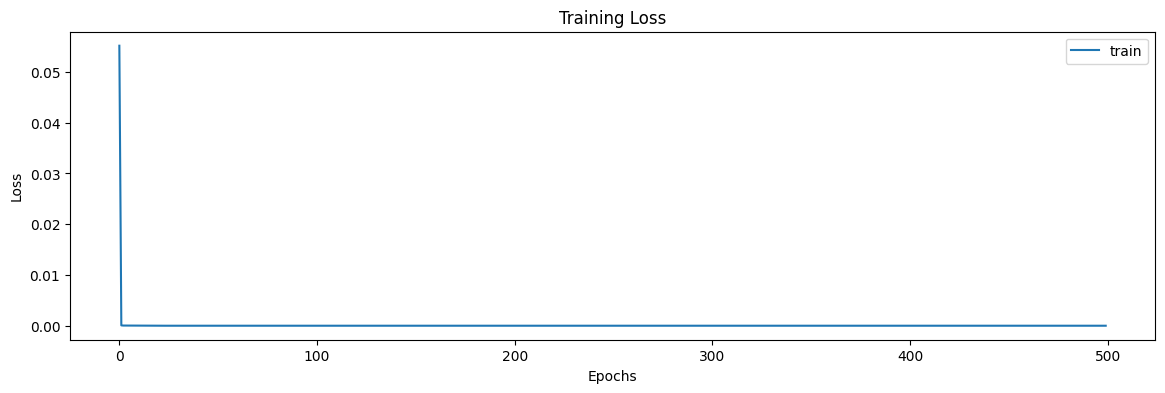

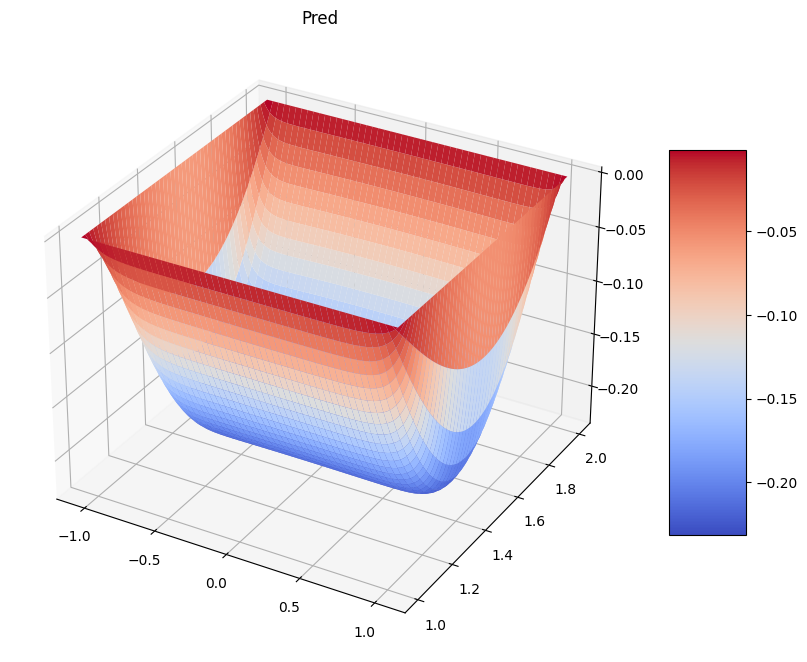

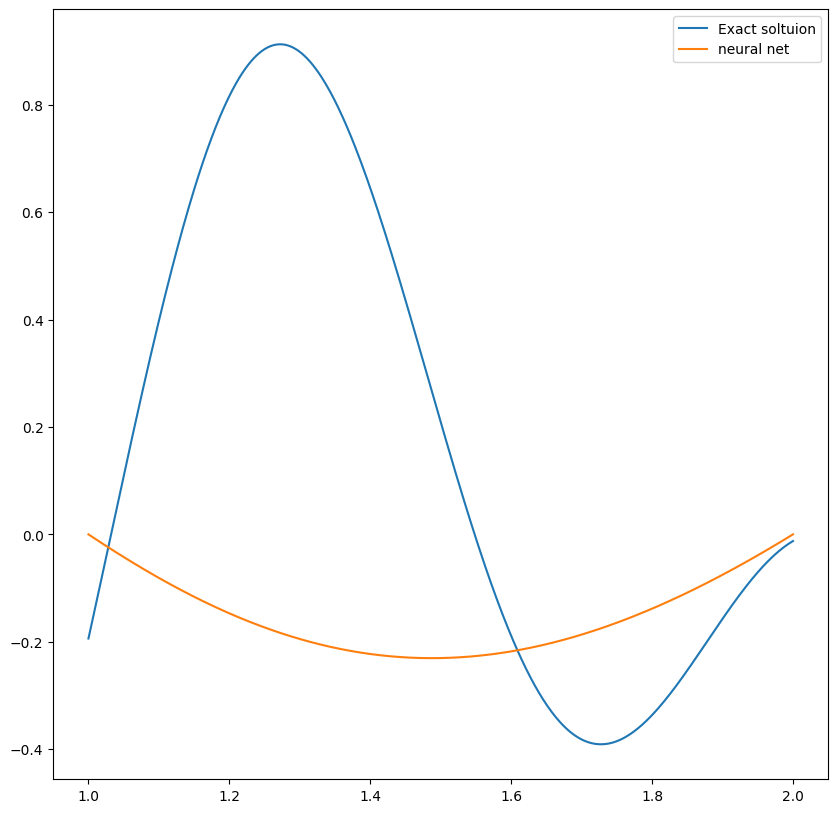

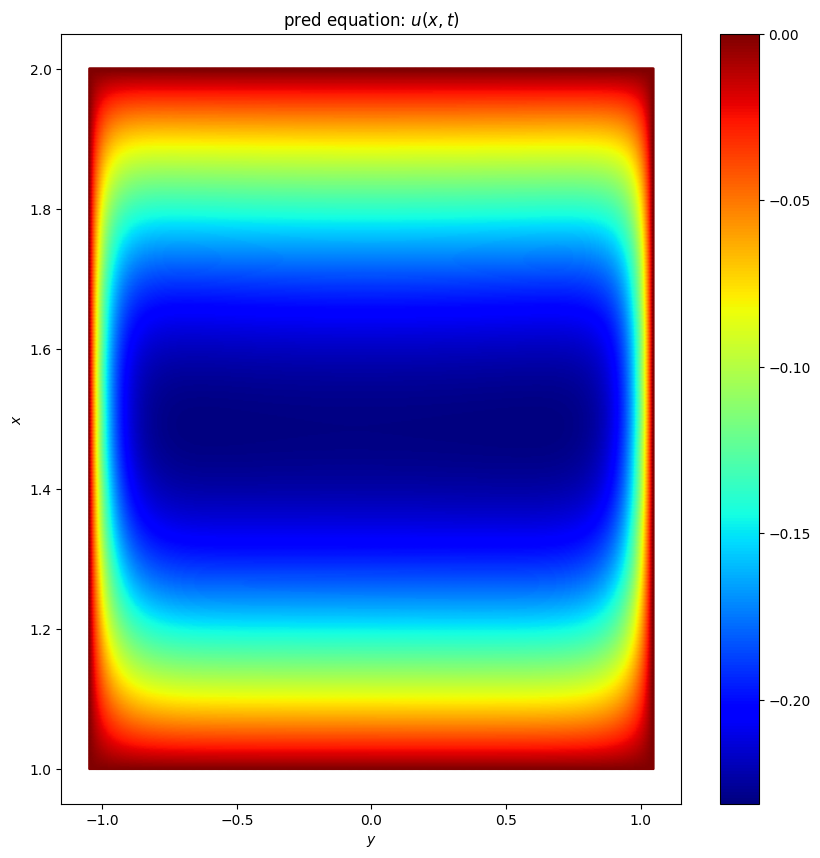

In [ ]:
################Showing results############
def save_loss(loss_list,path):
    plt.clf()
    plt.figure(figsize=(14,4))
    #print(train_loss, test_loss)
    plt.title("Training Loss")

    plt.plot(np.array(loss_list), label="train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(path + "/wave_loss.png")
    plt.savefig("wave_loss.png")



N=500
#######


def True_solution(rm,nm):
    return torch.sin(2*pi*rm*torch.cos(nm))*torch.sin(2*pi*rm*torch.sin(nm))
    #return (rm-1)*(rm-2)*torch.sin(pi*(nm-n0)\(n1-n0))
    #return (rm-1)*(rm-2)(nm-n0)*(nm-n1)
    #return torch.sin(2*pi*ym)*(70368744177664/(2778046668940015*ep) + (70368744177664*torch.exp((xm*((16*ep**2*pi**2 + 1)**(1/2) - 1))/(2*ep))*(torch.exp(-((16*ep**2*pi**2 + 1)**(1/2) + 1)/(2*ep)) - 1))/(2778046668940015*ep*(torch.exp(((16*ep**2*pi**2 + 1)**(1/2) - 1)/(2*ep)) - torch.exp(-((16*ep**2*pi**2 + 1)**(1/2) + 1)/(2*ep)))) - (70368744177664*torch.exp(-(xm*((16*ep**2*pi**2 + 1)**(1/2) + 1))/(2*ep))*(torch.exp(((16*ep**2*pi**2 + 1)**(1/2) - 1)/(2*ep)) - 1))/(2778046668940015*ep*(torch.exp(((16*ep**2*pi**2 + 1)**(1/2) - 1)/(2*ep)) - torch.exp(-((16*ep**2*pi**2 + 1)**(1/2) + 1)/(2*ep)))))


def save_image(N,path,k):

    X11 = torch.linspace(r1,r2,steps=N).type(torch.float64).to(DEVICE)
    Y11=torch.linspace(-math.pi/3,math.pi/3,steps=N).type(torch.float64).to(DEVICE)
    X1,Y1 = torch.meshgrid(X11, Y11)
    X=X1.reshape([N**2,1])
    Y=Y1.reshape([N**2,1])

    ######Plot predicted solution in 3d######
    if k==1:
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(projection = '3d')

        _,Z_p=model(X,Y)
        Z_p=Z_p.reshape([N,N])
    #print(Z_p.shape)
    #Z=true_solution(X1,T1).to(device)
        surf=ax.plot_surface(Y1.cpu().numpy(), X1.cpu().numpy(),  Z_p.detach().cpu().numpy(),cmap=plt.cm.coolwarm)
        fig.colorbar(surf,shrink=0.5,aspect=5)
        plt.title('Pred')
        x = X11.cpu().numpy()
        y = Y11.cpu().numpy()
        z = Z_p.detach().cpu().numpy()

        #fname = 'polar_dat_f=1_ep=10^({logep:d})_[0,01;1,01].mat'
        #fname = 'polar_dat_f=1_ep=10^({logep:d})_[1,2].mat'

        #fname = 'polar_dat_f=(r-1)(r-2)_ep=10^({logep:d})_[0,01;1,01].mat'
        fname = 'polar_dat_f=(r-1)(r-2)_ep=10^({logep:d})_[1,2].mat'

        fname = fname.format(logep = int(math.log10(ep)))
        scipy.io.savemat(fname, dict(x=x, y=y, z=z))
    #plt.legend(loc=2, prop={'size': 15})
        plt.savefig(path + "/wave_pred.png")

    #####compare with True and Pred solution at y=0.25#####
    if k==2:
        fig = plt.figure(figsize=(10,10))
        y=torch.tensor(0.25).float().type(torch.float64).to(DEVICE)
        X11=X11.unsqueeze(1)
        _,Z_p=model(X11,y.unsqueeze(0).unsqueeze(1))#.cpu().numpy()
        Z=True_solution(X11,y.unsqueeze(0).unsqueeze(1))#.cpu().numpy()
        plt.plot(X11.cpu().numpy(), Z.cpu().numpy(), label="Exact soltuion")
        plt.plot(X11.cpu().numpy(), Z_p.detach().cpu().numpy(), label="neural net")
        plt.legend()
        plt.savefig(path + "/true_vs_pred_at_t.png")
        np.save('/content/drive/MyDrive/ETD_using_NN/Code/data.npy', Z_p.detach().cpu().numpy())


    #####Plot predicted solution in 2d######
    if k==3:
        fig = plt.figure(figsize=(10,10))
        _,Z_p=model(X,Y)
        #Z_p=true_solution(X1,Y1)#.to(device)
        #Z=Z.numpy()
        plt.scatter(Y.cpu(), X.cpu(),  c=Z_p.detach().cpu().numpy(), s=1, cmap="jet")
        plt.colorbar()
        plt.xlabel('$y$')
        plt.ylabel('$x$')
        plt.title("pred equation: $u(x,t)$")
        plt.savefig(path + "/wave_2d_pred.png")
    plt.show

save_loss(Loss_list,log_path)
save_image(N,log_path,1)
save_image(N,log_path,2)
save_image(N,log_path,3)
